<a href="https://colab.research.google.com/github/hardikroutray/ECG/blob/main/ECG.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Import libraries or install unavailable libraries**

In [1]:
import pandas as pd
import numpy as np
import matplotlib as plt
import matplotlib.pyplot as plt
%matplotlib inline
%pylab inline
%config InlineBackend.figure_formats = ['retina']
from imutils import paths
import time   # time1 = time.time(); print('Time taken: {:.1f} sec'.format(time.time() - time1))
import cv2
import pickle
import warnings
warnings.filterwarnings("ignore")

Populating the interactive namespace from numpy and matplotlib


In [2]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.optimizers import Adam
from keras.utils import to_categorical
from keras.preprocessing import image
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
from tqdm import tqdm

In [3]:
from google.colab import drive
drive.mount._DEBUG = True
drive.mount('/content/MyDrive', force_remount=True)
!ls /content/MyDrive/MyDrive/ECG/data_v1/

unset HISTFILE; export PS1="root@5c819337bebf-c4f2e85aee47415b988b48c5308ba388: "
bash: cannot set terminal process group (-1): Inappropriate ioctl for device
bash: no job control in this shell
/content# root@5c819337bebf-c4f2e85aee47415b988b48c5308ba388: umount -f /content/MyDrive || umount /content/MyDrive; pkill -9 -x drive
umount: /content/MyDrive: no mount point specified.
umount: /content/MyDrive: no mount point specified.
root@5c819337bebf-c4f2e85aee47415b988b48c5308ba388: pkill -9 -f /opt/google/drive/directoryprefetcher_binary
root@5c819337bebf-c4f2e85aee47415b988b48c5308ba388: ( while `sleep 0.5`; do if [[ -d "/content/MyDrive" && "$(ls -A /content/MyDrive)" != "" ]]; then echo "google.colab.drive MOUNTED"; break; fi; done ) &
[1] 128
root@5c819337bebf-c4f2e85aee47415b988b48c5308ba388: cat /tmp/tmpr_rryoxn/drive.fifo | head -1 | ( /opt/google/drive/drive --features=fuse_max_background:1000,max_read_qps:1000,max_write_qps:1000,max_operation_batch_size:15,max_parallel_push_task

# **Study and process images for input into NN**

1.   A 12-lead based ECG image standard in hospitals
2.   A single image need to be cropped (better option ?) into 12 images. As a first pass, the entire image is used for classification
3. Each image is converted to a np array


In [33]:
# img = cv2.imread("/content/MyDrive/MyDrive/ECG/data/NormalPersonECGImages/Normal_1.jpg")
# print(img.shape)
# print(img[0][0])
# print(img[1000][1000])
# print(img[1571][2212])
# x_list, y_list = [], []

# for x in np.arange(0, 2213, 1):
#     for y in np.arange(0, 1572, 1):
#         if np.all(image[y][x] == (0, 0, 0)):   # black
#             x_list.append(x)
#             y_list.append(1572-y)
# show_graph(x_list, y_list, 20, 15)

(1572, 2213, 3)

<class 'PIL.Image.Image'>
None
L
(2213, 1572)


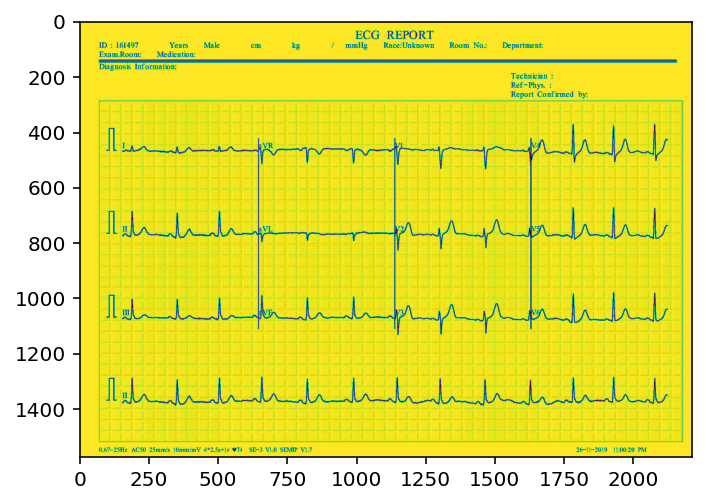

In [6]:
img = image.load_img('/content/MyDrive/MyDrive/ECG/data_v1/NormalPersonECGImages/Normal_1.jpg', grayscale=True) #target_size=(28,28), grayscale=True

print(type(img))
print(img.format)
print(img.mode)
print(img.size)
# show the image
plt.imshow(img)

In [7]:
img_array = image.img_to_array(img)
print(img_array.dtype)
print(img_array.shape)
img_back = image.array_to_img(img_array)
# plt.imshow(img_back)

float32
(1572, 2213, 1)


**Broadly classify into five groups as a first pass** 

1.   Need to be classified into 12*5 = 50 classes




In [9]:
#Make a dataframe with first column as the path to images and the second column as the labels
import os

images = []
labels = []

dirs = ['ECGImagesofCOVID-19Patients','ECGImagesofMyocardialInfarctionPatients', 'ECGImagesofPatientthathaveabnormalheartbeats', 'ECGImagesofPatientthathaveHistoryofMI', 'NormalPersonECGImages']

for dir in dirs:
  print(dir)
  for filename in os.listdir('/content/MyDrive/MyDrive/ECG/data_v1/{}'.format(dir)):
    if filename.endswith("jpg"): 
      # print(dir,filename)
      images.append('/content/MyDrive/MyDrive/ECG/data_v1/{}/{}'.format(dir,filename))
      if dir == 'ECGImagesofCOVID-19Patients':
        labels.append(1)
      if dir == 'ECGImagesofMyocardialInfarctionPatients':
        labels.append(2)
      elif dir == 'ECGImagesofPatientthathaveabnormalheartbeats':
        labels.append(3)
      elif dir == 'ECGImagesofPatientthathaveHistoryofMI':
        labels.append(4)
      elif dir == 'NormalPersonECGImages':
        labels.append(0)

df = pd.DataFrame({"image":images, "label":labels})
df
df.to_csv("ECG.csv", index=False)
!cp "ECG.csv" "/content/MyDrive/MyDrive/ECG/"

ECGImagesofCOVID-19Patients
ECGImagesofMyocardialInfarctionPatients
ECGImagesofPatientthathaveabnormalheartbeats
ECGImagesofPatientthathaveHistoryofMI
NormalPersonECGImages


In [10]:
df

,image,label
0,/content/MyDrive/MyDrive/ECG/data_v1/ECGImages...,1
1,/content/MyDrive/MyDrive/ECG/data_v1/ECGImages...,1
2,/content/MyDrive/MyDrive/ECG/data_v1/ECGImages...,1
3,/content/MyDrive/MyDrive/ECG/data_v1/ECGImages...,1
4,/content/MyDrive/MyDrive/ECG/data_v1/ECGImages...,1
...,...,...
1927,/content/MyDrive/MyDrive/ECG/data_v1/NormalPer...,0
1928,/content/MyDrive/MyDrive/ECG/data_v1/NormalPer...,0
1929,/content/MyDrive/MyDrive/ECG/data_v1/NormalPer...,0
1930,/content/MyDrive/MyDrive/ECG/data_v1/NormalPer...,0


# **Convert all images into np arrays and divide into training and test dataset, build the model and train your network**

In [11]:
imagedata = []
for i in tqdm(range(df.shape[0])):
    img = image.load_img('{}'.format(df["image"][i]), target_size=(28,28,1), grayscale=True)
    img = image.img_to_array(img)
    img = img/255
    imagedata.append(img)
X = np.array(imagedata)

100%|██████████| 1932/1932 [13:23<00:00,  2.40it/s]


In [12]:
y=df['label'].values
y = to_categorical(y) #one-hot encoding

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=100, test_size=0.2)

In [27]:
model = Sequential()
model.add(Conv2D(128, kernel_size=(3, 3),activation='relu',input_shape=(28,28,1)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(5, activation='softmax'))

In [28]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 26, 26, 128)       1280      
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 24, 24, 64)        73792     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 12, 12, 64)        0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 12, 12, 64)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 10, 10, 32)        18464     
_________________________________________________________________
flatten_2 (Flatten)          (None, 3200)              0         
_________________________________________________________________
dense_6 (Dense)              (None, 64)               

In [29]:
model.compile(loss='categorical_crossentropy',
              optimizer=Adam(),
              metrics=['accuracy'])

In [30]:
history=model.fit(X_train, y_train, epochs=12, validation_data=(X_test, y_test))

Epoch 1/12
49/49 [==============================] - 13s 258ms/step - loss: 1.4519 - accuracy: 0.3753 - val_loss: 1.4023 - val_accuracy: 0.4083
Epoch 2/12
49/49 [==============================] - 12s 253ms/step - loss: 1.3779 - accuracy: 0.4470 - val_loss: 1.4340 - val_accuracy: 0.4083
Epoch 3/12
49/49 [==============================] - 13s 256ms/step - loss: 1.3264 - accuracy: 0.4488 - val_loss: 1.2253 - val_accuracy: 0.4910
Epoch 4/12
49/49 [==============================] - 12s 254ms/step - loss: 1.1061 - accuracy: 0.5755 - val_loss: 0.9480 - val_accuracy: 0.6305
Epoch 5/12
49/49 [==============================] - 13s 256ms/step - loss: 0.9322 - accuracy: 0.6596 - val_loss: 0.9167 - val_accuracy: 0.6279
Epoch 6/12
49/49 [==============================] - 12s 255ms/step - loss: 0.8857 - accuracy: 0.6556 - val_loss: 0.9136 - val_accuracy: 0.6382
Epoch 7/12
49/49 [==============================] - 13s 257ms/step - loss: 0.8680 - accuracy: 0.6637 - val_loss: 0.8612 - val_accuracy: 0.6563

In [32]:
score = model.evaluate(X_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.8901693820953369
Test accuracy: 0.6459948420524597


In [35]:
history_dict = history.history
print(history_dict.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


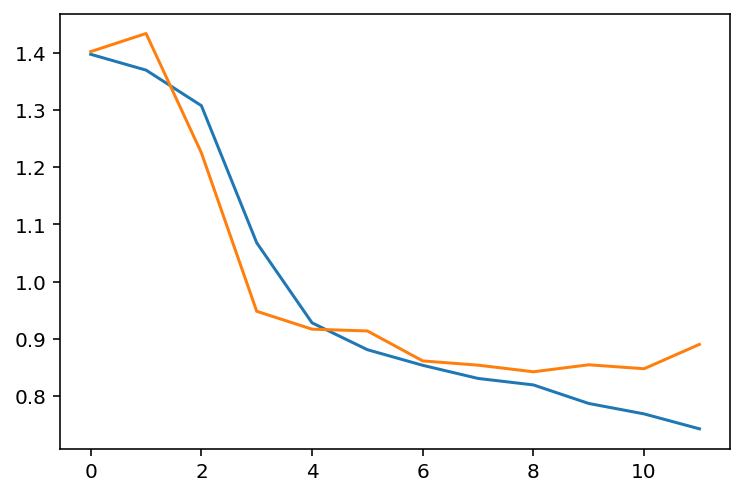

In [33]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

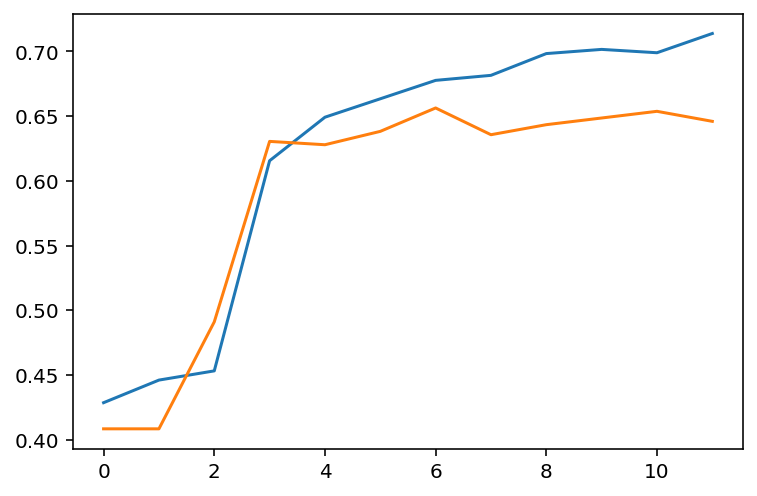

In [36]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])